# Section B: Recurrent Nueral Network

Name: Joen Choo Tze En<br>
Admin Number: P2415828<br>
Class: DAAA/FT/2B/22<br>

## Project Objective
To build an appropriate deep neural network, that can provide an analysis of movie reviews.<br/>
We want to make a *Regression* model using Recurrent Nueral Networks

## Background Reasearch
Movie Reviews are able to let us evaluate movies, through audience perception and reception. They allow us to highlight what may be good or bad in the production.

---

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import random
import warnings
warnings.filterwarnings("ignore")

from deep_translator import GoogleTranslator
import re
import nlpaug.augmenter.word as naw
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LeakyReLU, Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dropout
from keras.metrics import MeanSquaredError
from keras.regularizers import l2

# Set the random seed
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
random_state = 42

In [30]:
df = pd.read_csv('Datasets/Movie reviews.csv')
print(df.shape)
df

(527, 4)


,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,NaN,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,NaN,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,NaN,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,NaN,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,NaN,Malay
...,...,...,...,...
522,Pening,0.7,NaN,Malay
523,Berkesan,0.2,NaN,Malay
524,Mengujakan,0.1,NaN,Malay
525,Sederhana and teruk,0.6,NaN,Malay


# | Exploratory Data Analysis

In [31]:
df.isna().sum()

Review                                                                                     0
Score                                                                                      2
Are there ways for you to generate more data? Spliting up sentences, would that help?    527
Language                                                                                   0
dtype: int64

In [32]:
display(df['Are there ways for you to generate more data? Spliting up sentences, would that help?'])
df['Are there ways for you to generate more data? Spliting up sentences, would that help?'].notna().sum()
df = df.drop(['Are there ways for you to generate more data? Spliting up sentences, would that help?'], axis=1)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
522   NaN
523   NaN
524   NaN
525   NaN
526   NaN
Name: Are there ways for you to generate more data? Spliting up sentences, would that help?, Length: 527, dtype: float64

In [33]:
df[df['Score'].isna()]

,Review,Score,Language
426,Ni hao,NaN,Chinese
493,Diabolic,NaN,English


In [34]:
# Drop the rows with missing values
df = df.dropna()

In [35]:
df['Language'].value_counts()

Language
English    297
Malay      226
Chinese      1
Nippon       1
Name: count, dtype: int64

In [36]:
df[df['Language'] == 'Nippon']

,Review,Score,Language
484,Nani kore,0.997413,Nippon


In [37]:
df[df['Language'] == 'Chinese']

,Review,Score,Language
427,Hen tai fei chang hao,0.001,Chinese


In [38]:
df[df['Language'] == 'Malay'].head(10)

,Review,Score,Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.10,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.90,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.50,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.80,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.20,Malay
5,Pembuat filem berjaya memberikan pengalaman ya...,0.05,Malay
6,Adegan aksi yang terlalu banyak dan mengejutka...,0.40,Malay
7,Saya teruja sepanjang filem. Penceritaan yang ...,0.15,Malay
8,Avengers: Endgame mengecewakan dan membosankan...,0.85,Malay
9,Integrasi elemen fiksyen sains sangat menarik....,0.25,Malay


In [39]:
df[df['Language'] == 'English'].head(12)

,Review,Score,Language
206,This movie is amazing! The action is breathtak...,0.08,English
207,I'm disappointed with the actors' performance....,0.70,English
208,The storyline is touching and full of emotion....,0.12,English
209,This movie delivers an outstanding experience....,0.05,English
210,"Too many action scenes, sometimes unnecessary....",0.40,English
211,I'm thrilled throughout the movie. Engaging st...,0.15,English
212,Avengers: Endgame is disappointing and too cli...,0.85,English
213,I like how this movie combines elements of sci...,0.25,English
214,This film is truly impressive with deep emotio...,0.12,English
215,A cinematic experience that is unforgettable. ...,0.10,English


It seems that the higher the score the more negative the sentiment

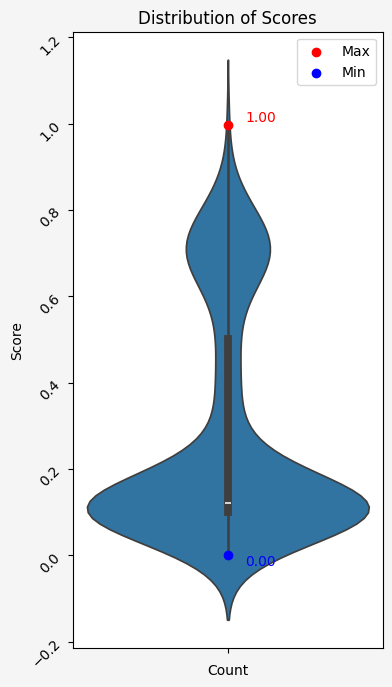

In [40]:
# Plot the distribution of the scores vertically
plt.figure(figsize=(4, 8), facecolor='whitesmoke')
sns.violinplot(y='Score', data=df)
plt.title('Distribution of Scores')
plt.ylabel('Score')
plt.xlabel('Count')
plt.yticks(rotation=45)
# Find and plot the maximum and minimum scores
max_score = df['Score'].max()
min_score = df['Score'].min()
plt.scatter(0, max_score, color='red', label="Max", zorder=5)
plt.scatter(0, min_score, color='blue', label="Min", zorder=5)
plt.text(0.05, max_score, f"{max_score:.2f}", color='red', va='bottom')
plt.text(0.05, min_score, f"{min_score:.2f}", color='blue', va='top')
plt.legend()
plt.show()

Observations:
- Large amount of low scores (high positive reviews)
- All scores are within 0 and 1 inclusive

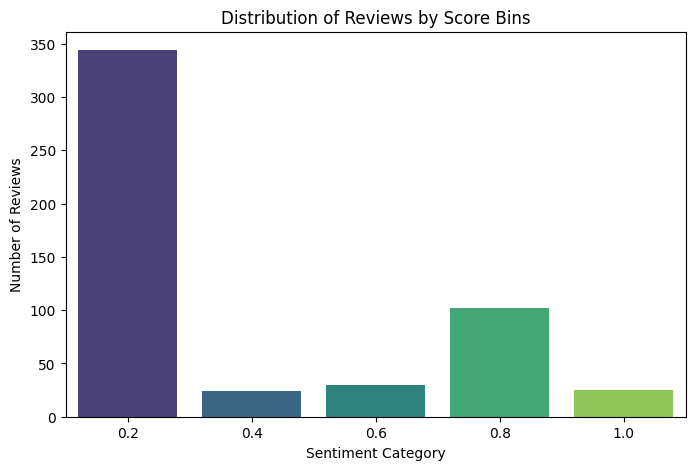

In [41]:
dataset = df.copy()
# Bin the 'Score' column into 5 equal-width bins
bin_labels = [0.2, 0.4, 0.6, 0.8, 1.0]
dataset['Score Bin'] = pd.cut(dataset['Score'], bins=5, labels=bin_labels, include_lowest=True)

# Plot the distribution of reviews in each bin
plt.figure(figsize=(8, 5))
sns.countplot(data=dataset, x='Score Bin', order=bin_labels, palette='viridis')
plt.title('Distribution of Reviews by Score Bins')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.show()

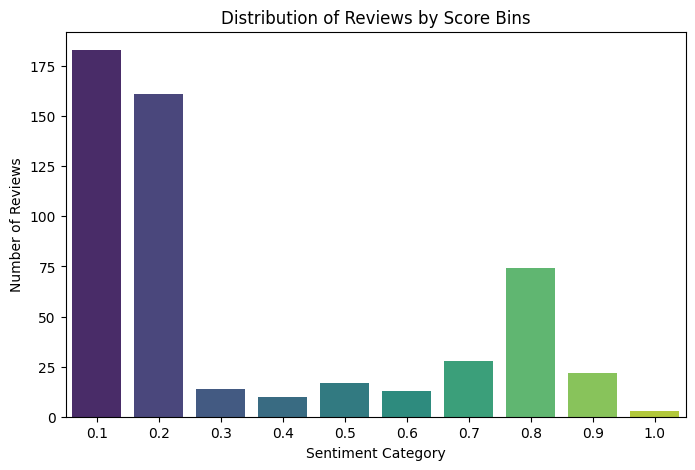

In [42]:
bin_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dataset['Score Bin'] = pd.cut(dataset['Score'], bins=10, labels=bin_labels, include_lowest=True)

# Plot the distribution of reviews in each bin
plt.figure(figsize=(8, 5))
sns.countplot(data=dataset, x='Score Bin', order=bin_labels, palette='viridis')
plt.title('Distribution of Reviews by Score Bins')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.show()

The dataset is very heavily skewed and even changing bin size will not help much, hence a *classification* model will be hard to implement unless we augment decently large amount of data (which might be hard to carry out)

# | Data Preprocessing

## Drop Duplicates
There are some duplicate review sentences but with differing scores so we will drop them

In [43]:
df = df.drop_duplicates(subset='Review', keep=False).reset_index(drop=True)
print(f"Total Unduplicated Dataset: {df.shape}")

Total Unduplicated Dataset: (312, 3)


## Translate Languages
There are reviews of different languages, I will handle this by translating them all to a common language which will be English

In [44]:
# GoogleTranslator from deep_translator

def translate(text):
    return GoogleTranslator(source='auto', target="en").translate(text)

In [45]:
non_english = df[df["Language"] != "English"]
df = df[df["Language"] == "English"]

print(f"Dataset (English) Shape: {df.shape}")
print(f"Dataset (Non-English) Shape: {non_english.shape}")

Dataset (English) Shape: (247, 3)
Dataset (Non-English) Shape: (65, 3)


In [46]:
non_english.loc[:,"Review"] = list(map(translate, non_english.loc[:,"Review"]))

In [47]:
translated_data = pd.concat([df, non_english], ignore_index=True, axis=0)
print(f"Total Translated Dataset: {translated_data.shape}")
translated_data.tail()

Total Translated Dataset: (312, 3)


,Review,Score,Language
307,Dizzy,0.7,Malay
308,Effective,0.2,Malay
309,Exciting,0.1,Malay
310,Moderate and severe,0.6,Malay
311,Perfect,0.1,Malay


In [48]:
translated_data.rename(columns={'Language': 'Original Language'}, inplace=True)

## Sentence Splitting (Data Engineering)
A process where the review sentences are split so that more data/features are created<br/>
Each split sentence will still keep their original Score

In [49]:
nlp = spacy.load("en_core_web_sm")
split_sentences = []
split_scores = []
split_languages = []

for idx, row in translated_data.iterrows():
    # Split sentences using regex for punctuation
    sentences = re.split(r'(?<=[.!?])\s+', row['Review'])
    # Remove empty strings
    sentences = [s.strip() for s in sentences if s.strip()]
    split_sentences.extend(sentences)
    split_scores.extend([row['Score']] * len(sentences))
    split_languages.extend([row['Original Language']] * len(sentences))

split_sentence_data = pd.DataFrame({
    'Review': split_sentences,
    'Score': split_scores,
    'Original Language': split_languages
})

In [50]:
print(f"Total Augmented Dataset: {split_sentence_data.shape}")
split_sentence_data.head(10)

Total Augmented Dataset: (545, 3)


,Review,Score,Original Language
0,This movie is amazing!,0.08,English
1,"The action is breathtaking, and the plot is in...",0.08,English
2,I'm disappointed with the actors' performance.,0.70,English
3,Not satisfying.,0.70,English
4,The storyline is touching and full of emotion.,0.12,English
5,I love it!,0.12,English
6,This movie delivers an outstanding experience.,0.05,English
7,Truly captivating!,0.05,English
8,"Too many action scenes, sometimes unnecessary.",0.40,English
9,Too dramatic.,0.40,English


## Synonym Replacement (Data Augmentation)

In [51]:
augmented_list = []
augmented_df = translated_data.copy()

# Create a synonym augmenter using WordNet
synonym_aug = naw.SynonymAug(aug_src='wordnet')

for sentence in augmented_df["Review"]:
    augmented_list += synonym_aug.augment(sentence)

augmented_df["Review"] = augmented_list

aug_translated_data = pd.concat([translated_data, augmented_df], ignore_index=True, axis=0)
print(f"Before Adding Data: {translated_data.shape}")
print(f"After Adding Data: {aug_translated_data.shape}")

Before Adding Data: (312, 3)
After Adding Data: (624, 3)


Effectively doubled the dataset

## Lemmatization
A process that reduces all words' forms into its root form, this simplifies the vocabulary size

In [52]:
nlp = spacy.load("en_core_web_sm")

lemmatized_sentences = []
lemmatized_data = aug_translated_data.copy()

for sentence in aug_translated_data["Review"]:
    doc = nlp(sentence)
    lemmatized_words = [token.lemma_ for token in doc]

    lemmatized_sentences += [' '.join(lemmatized_words)]

lemmatized_data["Review"] = lemmatized_sentences

In [53]:
lemmatized_data.head(10)

,Review,Score,Original Language
0,this movie be amazing ! the action be breathta...,0.08,English
1,I be disappointed with the actor ' performance...,0.70,English
2,the storyline be touching and full of emotion ...,0.12,English
3,this movie deliver an outstanding experience ....,0.05,English
4,"too many action scene , sometimes unnecessary ...",0.40,English
5,I be thrilled throughout the movie . engage st...,0.15,English
6,avenger : Endgame be disappointing and too cli...,0.85,English
7,I like how this movie combine element of scien...,0.25,English
8,this film be truly impressive with deep emotio...,0.12,English
9,a cinematic experience that be unforgettable ....,0.10,English


## Stopword Removal
A further step for simplifying the vocabulary size, by removing extremely common words and punctuations (as they are not useful for our model)<br/>
I would also like to keep negating words like "not" as I deem them important for the meaning of the sentences

In [54]:
custom_stopwords = STOP_WORDS - {'not'}

def remove_stopwords_and_punct(text):
    return ' '.join([
        word for word in text.split()
        if word.lower() not in custom_stopwords and word not in string.punctuation
    ])

lemmatized_data['Review'] = lemmatized_data['Review'].apply(remove_stopwords_and_punct)

In [55]:
lemmatized_data.head(10)

,Review,Score,Original Language
0,movie amazing action breathtaking plot intriguing,0.08,English
1,disappointed actor performance not satisfy,0.70,English
2,storyline touching emotion love,0.12,English
3,movie deliver outstanding experience truly cap...,0.05,English
4,action scene unnecessary dramatic,0.40,English
5,thrilled movie engage storytelling,0.15,English
6,avenger Endgame disappointing cliché not enjoy...,0.85,English
7,like movie combine element science fiction int...,0.25,English
8,film truly impressive deep emotional tone,0.12,English
9,cinematic experience unforgettable impressed,0.10,English


## Tokenization
Text needs to be converted to integers before they can be used as input for the neural network

In [56]:
# Initialize the tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(lemmatized_data['Review'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(lemmatized_data['Review'])
vocab_size = len(tokenizer.word_index) + 1

# Example sequences
print("Example sequences:", sequences[0:5])
print("Vocabulary size:", vocab_size)

Example sequences: [[16, 31, 4, 45, 3, 165], [310, 26, 17, 28, 81], [46, 166, 59, 62], [16, 22, 37, 12, 40, 67], [4, 15, 201, 82]]
Vocabulary size: 1039


## Padding
We want to get each datapoint(review sentence) to the same length, before passing it into the neural network

In [57]:
# Determine the maximum sequence length
max_length = max(len(seq) for seq in sequences)
print("Maximum sequence length:", max_length)

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

print("Shape of padded_sequences:", padded_sequences.shape)
print("Example padded sequences:\n", padded_sequences[0:5])

Maximum sequence length: 34
Shape of padded_sequences: (624, 34)
Example padded sequences:
 [[ 16  31   4  45   3 165   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [310  26  17  28  81   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 46 166  59  62   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 16  22  37  12  40  67   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  4  15 201  82   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


## Embedding
A form of Dimensionality Reduction, which we may not need to implement as our vocabulary size is not that large

In [58]:
# Create an Embedding layer for the input data
embedding_dim = 10

embedding_layer = Embedding(
	input_dim=vocab_size,
	output_dim=embedding_dim,
	input_length=max_length
)

# Example: Pass the padded_sequences through the embedding layer
embedded_sequences = embedding_layer(padded_sequences)

print("Shape of embedded_sequences:", embedded_sequences.shape)
print("Example embedded sequence:\n", embedded_sequences[[0]].numpy())

Shape of embedded_sequences: (624, 34, 10)
Example embedded sequence:
 [[ 2.48931684e-02  1.27210282e-02  4.43054102e-02 -1.01358183e-02
   5.56959957e-03 -4.69141118e-02 -4.23669815e-02 -3.75352800e-04
  -3.09040193e-02 -3.13056484e-02]
 [ 3.06630135e-03  3.09446119e-02  5.00515848e-03  1.64595991e-03
   1.78421848e-02  2.28063352e-02  3.80908325e-03 -3.45844850e-02
  -2.07734592e-02  4.12260778e-02]
 [ 7.98400491e-03  9.74196196e-03 -1.56795755e-02 -3.49343196e-02
   3.66886146e-02 -1.07316263e-02 -2.91603804e-02 -4.31677215e-02
  -2.78926026e-02  3.47343571e-02]
 [-3.86422761e-02  2.87766568e-02 -1.67386308e-02  4.60294001e-02
  -1.81016438e-02 -2.24069487e-02 -1.57255530e-02  1.58423074e-02
  -9.08627361e-03  4.65567149e-02]
 [ 3.98194529e-02 -4.28115204e-03  1.56754740e-02 -4.95793112e-02
   4.53055762e-02  5.22036478e-03  3.97118069e-02  4.66122963e-02
  -5.23900986e-03 -2.31759436e-02]
 [-4.88820672e-02 -4.26392332e-02  4.34163921e-02 -5.89948893e-03
   1.79331191e-02 -9.6341148

# Modelling

## Preparation of Data for Training

In [59]:
X = padded_sequences
y = lemmatized_data['Score'].values.reshape(-1, 1)

X_embedded = embedded_sequences.numpy()
y_embedded = y

In [60]:
print(f"X_shape {X.shape}")
print(f"y_shape {y.shape}")
print(f"X_embedded_shape {X_embedded.shape}")
print(f"y_embedded_shape {y_embedded.shape}")

X_shape (624, 34)
y_shape (624, 1)
X_embedded_shape (624, 34, 10)
y_embedded_shape (624, 1)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, shuffle=True, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=random_state)
print(f"Shape X_test: {X_test.shape}")
print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_val: {X_val.shape}")

Shape X_test: (125, 34)
Shape X_train: (374, 34)
Shape X_val: (125, 34)


## Model Training

In [62]:
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    y_pred = np.clip(y_pred, 0, 1)  # Ensure predictions are within the range [0, 1]
    
    # Calculate Mean Squared Error
    mse = np.mean((y_true - y_pred) ** 2)
    
    # Calculate R-squared
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    return [mse, r_squared]

In [63]:
def plot_learning_curve(history):
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    
    # Training loss and validation loss
    ax1=ax[0]
    ax1.plot(history.history["loss"], label="Training Loss")
    ax1.plot(history.history["val_loss"], label="Validation Loss")
    ax1.legend()
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Number of Epochs")
    ax1.set_title("Training and Validation Loss")

    # Training accuracy and validation mean squared error
    ax2=ax[1]
    ax2.plot(history.history["mean_squared_error"], label="Training MSE")
    ax2.plot(history.history["val_mean_squared_error"], label="Validation MSE")
    ax2.legend()
    ax2.set_ylabel("Mean squared error")
    ax2.set_xlabel("Number of Epochs")
    ax2.set_title("Training and Validation MSE")
    plt.show()

In [78]:
baseline_regression = Sequential(
    name="baseline_regression",
    layers=[
    Embedding(vocab_size, 128, input_length=max_length),
    SimpleRNN(64, activation = LeakyReLU(alpha=0.01), dropout=0.3),
    Dense(1, activation='relu', kernel_regularizer=l2(0.01))
])

baseline_regression.compile(
    optimizer='rmsprop', 
    loss='mean_squared_error', 
    metrics=[MeanSquaredError()])
    
baseline_regression.summary()

Model: "baseline_regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 34, 128)           132992    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 145,409
Trainable params: 145,409
Non-trainable params: 0
_________________________________________________________________


In [79]:
baseline_regression_history = baseline_regression.fit(
    X_train,
    y_train, 
    epochs=50, 
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/50
12/12 [==============================] - 1s 55ms/step - loss: 0.1185 - mean_squared_error: 0.0999 - val_loss: 0.0925 - val_mean_squared_error: 0.0750
Epoch 2/50
12/12 [==============================] - 0s 40ms/step - loss: 0.0822 - mean_squared_error: 0.0653 - val_loss: 0.0893 - val_mean_squared_error: 0.0732
Epoch 3/50
12/12 [==============================] - 0s 39ms/step - loss: 0.0817 - mean_squared_error: 0.0662 - val_loss: 0.0893 - val_mean_squared_error: 0.0746
Epoch 4/50
12/12 [==============================] - 1s 45ms/step - loss: 0.0815 - mean_squared_error: 0.0672 - val_loss: 0.0892 - val_mean_squared_error: 0.0756
Epoch 5/50
12/12 [==============================] - 1s 44ms/step - loss: 0.0785 - mean_squared_error: 0.0653 - val_loss: 0.0868 - val_mean_squared_error: 0.0743
Epoch 6/50
12/12 [==============================] - 1s 44ms/step - loss: 0.0773 - mean_squared_error: 0.0652 - val_loss: 0.0848 - val_mean_squared_error: 0.0733
Epoch 7/50
12/12 [================

In [80]:
baseline_regression_testscore = evaluate_model(baseline_regression, X_test, y_test)
print(f"Baseline Regression Test MSE: {baseline_regression_testscore[0]}")
print(f"Baseline Regression Test R-squared: {baseline_regression_testscore[1]}")

4/4 [==============================] - 0s 5ms/step
Baseline Regression Test MSE: 0.05339681284356433
Baseline Regression Test R-squared: 0.2949244830740374


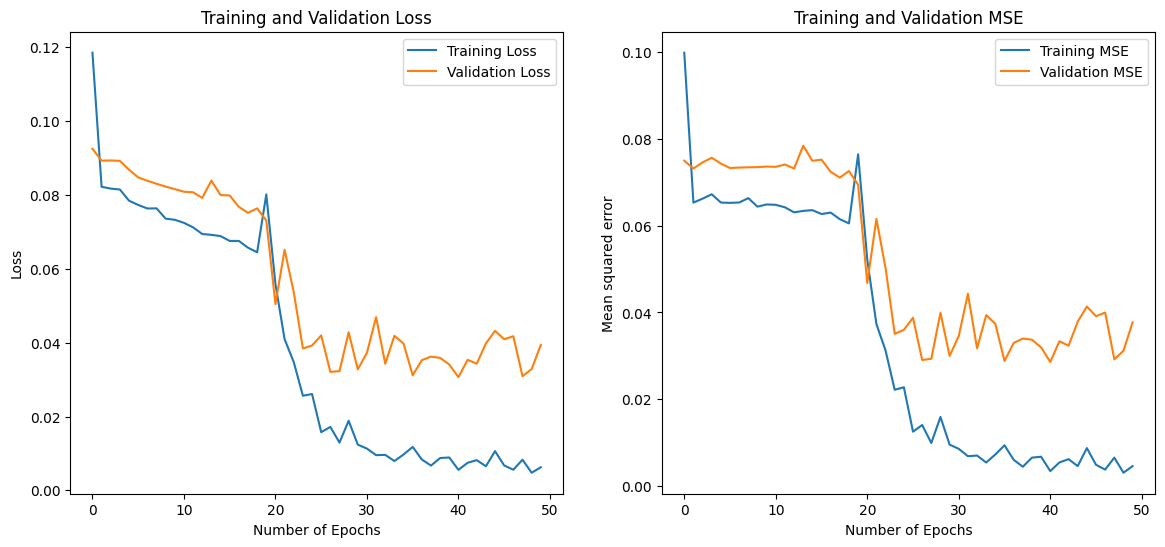

In [81]:
plot_learning_curve(baseline_regression_history)

A SimpleRNN model is not learning well (unstable graph)

## LTSM
As they compute the hidden state differently, by deciding what to keep and erase from the memory, they are efficient at capturing long term information

In [82]:
LSTM_model = Sequential(
    name="LSTM_model",
    layers=[
    Embedding(vocab_size,128, input_length=max_length),
    LSTM(100),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

LSTM_model.compile(
    optimizer='rmsprop', 
    loss='mean_squared_error', 
    metrics=[MeanSquaredError()])
    
LSTM_model.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 34, 128)           132992    
                                                                 
 lstm_1 (LSTM)               (None, 100)               91600     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 224,693
Trainable params: 224,693
Non-trainable params: 0
_________________________________________________________________


In [83]:
LSTM_model_history = LSTM_model.fit(
    X_train,
    y_train, 
    epochs=50, 
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/50
12/12 [==============================] - 1s 37ms/step - loss: 0.0934 - mean_squared_error: 0.0756 - val_loss: 0.0926 - val_mean_squared_error: 0.0762
Epoch 2/50
12/12 [==============================] - 0s 17ms/step - loss: 0.0809 - mean_squared_error: 0.0654 - val_loss: 0.0878 - val_mean_squared_error: 0.0735
Epoch 3/50
12/12 [==============================] - 0s 15ms/step - loss: 0.0791 - mean_squared_error: 0.0656 - val_loss: 0.0834 - val_mean_squared_error: 0.0707
Epoch 4/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0678 - mean_squared_error: 0.0557 - val_loss: 0.0663 - val_mean_squared_error: 0.0547
Epoch 5/50
12/12 [==============================] - 0s 12ms/step - loss: 0.0388 - mean_squared_error: 0.0277 - val_loss: 0.0535 - val_mean_squared_error: 0.0429
Epoch 6/50
12/12 [==============================] - 0s 12ms/step - loss: 0.0326 - mean_squared_error: 0.0225 - val_loss: 0.0477 - val_mean_squared_error: 0.0382
Epoch 7/50
12/12 [================

In [84]:
LSTM_model_testscore = evaluate_model(LSTM_model, X_test, y_test)
print(f"Baseline Regression Test MSE: {LSTM_model_testscore[0]}")
print(f"Baseline Regression Test R-squared: {LSTM_model_testscore[1]}")

4/4 [==============================] - 0s 1ms/step
Baseline Regression Test MSE: 0.021360873471396567
Baseline Regression Test R-squared: 0.7179414256622575


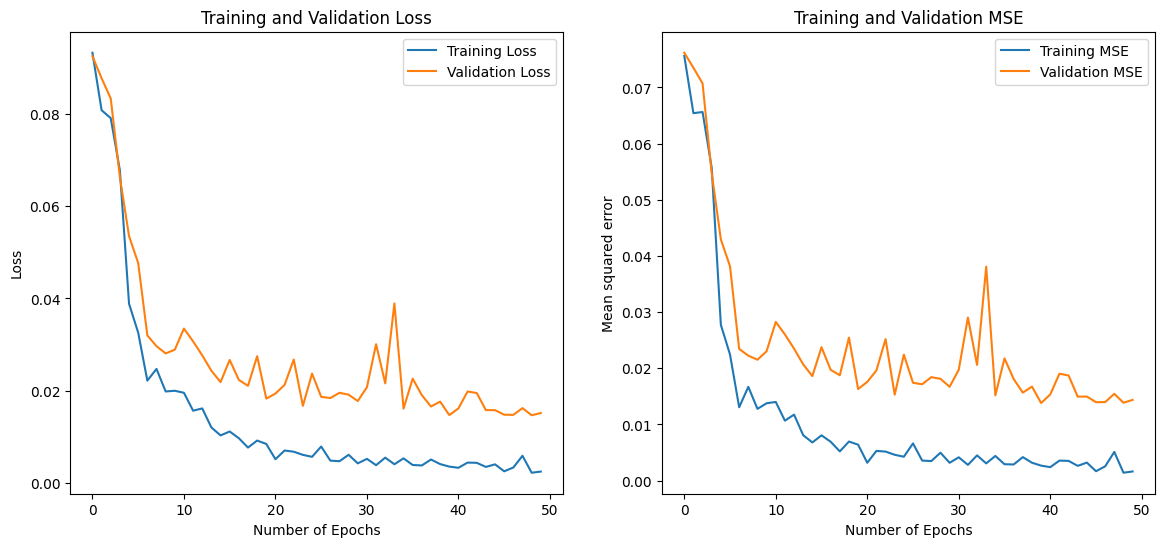

In [85]:
plot_learning_curve(LSTM_model_history)

## GRU

In [86]:
GRU_model = Sequential(
    name="GRU_model",
    layers=[
    Embedding(vocab_size,128, input_length=max_length),
    GRU(128, dropout=0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

GRU_model.compile(
    optimizer='rmsprop', 
    loss='mean_squared_error', 
    metrics=[MeanSquaredError()])
    
GRU_model.summary()

Model: "GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 34, 128)           132992    
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 232,193
Trainable params: 232,193
Non-trainable params: 0
_________________________________________________________________


In [87]:
GRU_model_history = GRU_model.fit(
    X_train,
    y_train, 
    epochs=50, 
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/50
12/12 [==============================] - 1s 35ms/step - loss: 0.0908 - mean_squared_error: 0.0735 - val_loss: 0.0909 - val_mean_squared_error: 0.0752
Epoch 2/50
12/12 [==============================] - 0s 14ms/step - loss: 0.0796 - mean_squared_error: 0.0650 - val_loss: 0.0874 - val_mean_squared_error: 0.0741
Epoch 3/50
12/12 [==============================] - 0s 13ms/step - loss: 0.0787 - mean_squared_error: 0.0663 - val_loss: 0.0857 - val_mean_squared_error: 0.0742
Epoch 4/50
12/12 [==============================] - 1s 48ms/step - loss: 0.0757 - mean_squared_error: 0.0648 - val_loss: 0.0860 - val_mean_squared_error: 0.0758
Epoch 5/50
12/12 [==============================] - 0s 12ms/step - loss: 0.0751 - mean_squared_error: 0.0656 - val_loss: 0.0827 - val_mean_squared_error: 0.0739
Epoch 6/50
12/12 [==============================] - 0s 12ms/step - loss: 0.0730 - mean_squared_error: 0.0647 - val_loss: 0.0815 - val_mean_squared_error: 0.0738
Epoch 7/50
12/12 [================

In [88]:
GRU_model_testscore = evaluate_model(GRU_model, X_test, y_test)
print(f"Baseline Regression Test MSE: {GRU_model_testscore[0]}")
print(f"Baseline Regression Test R-squared: {GRU_model_testscore[1]}")

4/4 [==============================] - 0s 3ms/step
Baseline Regression Test MSE: 0.027613446953913465
Baseline Regression Test R-squared: 0.635379635069647


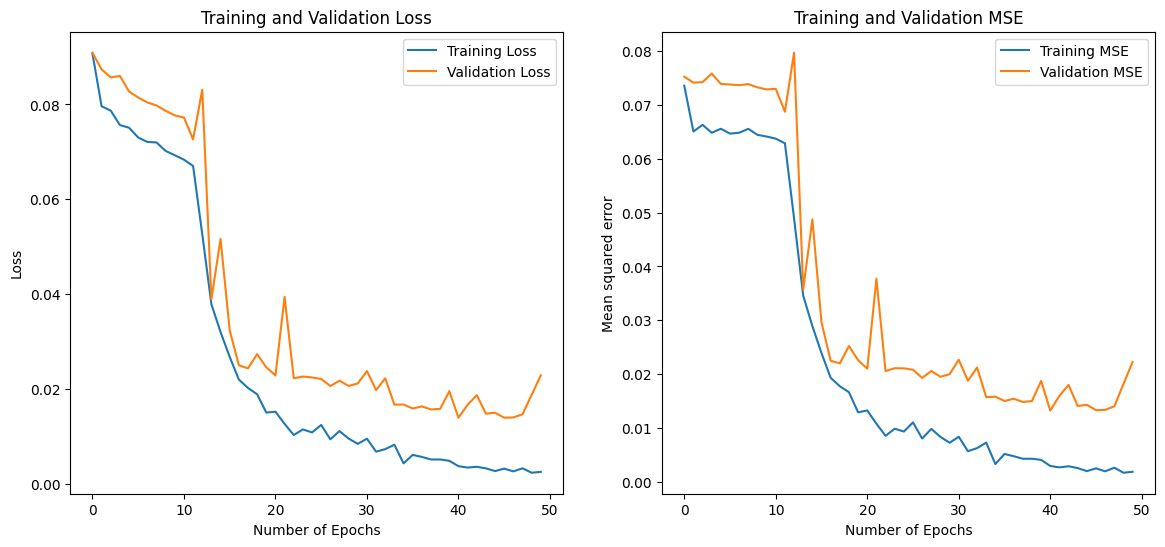

In [89]:
plot_learning_curve(GRU_model_history)